In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import seaborn as sns
from utils import ikomek_accuracy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from joblib import dump, load
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/mic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
data = pd.read_csv('data/contracts.csv',sep=';', header=None, names=['contract','service_id','service_name','user_request'])

In [33]:
data.head()

,contract,service_id,service_name,user_request
0,426,14,Муж на час,выкорчивать пень
1,429,14,Муж на час,выкорччпчивать пень
2,475,10,Электрик,не работает розетка в коридоре
3,573,13,Ремонт компьютеров,рейтинг нулевой
4,617,13,Ремонт компьютеров,пробный заказ на новой версии


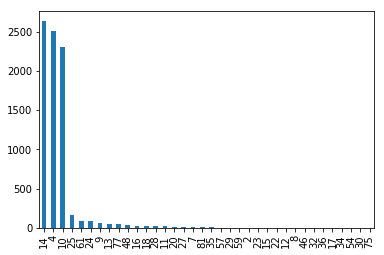

In [34]:
data.service_id.value_counts().plot(kind='bar')

In [35]:
data4 = data[~data.service_id.isin([14,10,4])].copy()
data4.head()

,contract,service_id,service_name,user_request
3,573,13,Ремонт компьютеров,рейтинг нулевой
4,617,13,Ремонт компьютеров,пробный заказ на новой версии
6,650,13,Ремонт компьютеров,пуш есть или нет на горячий заказ
7,651,13,Ремонт компьютеров,покрасить намордник у собаки
9,664,13,Ремонт компьютеров,сделать рекламу на окна


In [36]:
data.loc[~data.service_id.isin([14,10,4]), 'service_id'] = 0

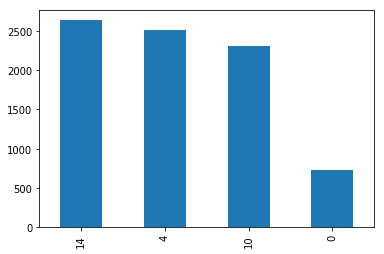

In [37]:
data.service_id.value_counts().plot(kind='bar')

In [38]:
vc = data4.service_id.value_counts().sort_values(ascending=False)[5:].index.tolist()
ind = data4[data4['service_id'].isin(vc)].index
data4.drop(ind, inplace=True)

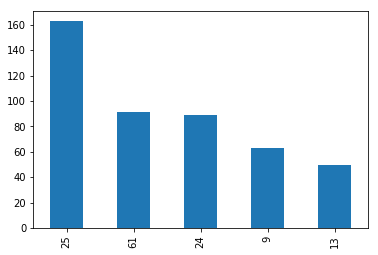

In [39]:
data4.service_id.value_counts().plot(kind='bar')

In [40]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^а-я ]')

In [41]:
def remove_stopwords(text: str) -> str:
        try:
            text = text.lower()
            text = REPLACE_BY_SPACE_RE.sub(' ', text)
            text = BAD_SYMBOLS_RE.sub('', text)
            return " ".join([token for token in text.split() if token not in mystopwords])
        except:
            return ""
        
def lemmatize(text: str) -> str:
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

def remove_stoplemmas(text: str) -> str:
    try:
        return " ".join([token for token in text.split() if token not in mystoplemmas])
    except:
        return ""

def clear_text(text: str) ->str:
    cText = remove_stopwords(text)
    cText = lemmatize(cText)
    cText = remove_stoplemmas(cText)
    return cText

In [42]:
m = Mystem()

In [43]:
mystopwords = stopwords.words('russian') + ['это', 'наш', 'тыс', 'млн', 'млрд', 'также',  'т', 'д','iKomek.kz','кв','для','тел']
mystoplemmas = ['который', 'прошлый', 'сей', 'свой', 'наш', 'мочь','заказ','адрес','телефон','тел']

In [44]:
data.head()

,contract,service_id,service_name,user_request
0,426,14,Муж на час,выкорчивать пень
1,429,14,Муж на час,выкорччпчивать пень
2,475,10,Электрик,не работает розетка в коридоре
3,573,0,Ремонт компьютеров,рейтинг нулевой
4,617,0,Ремонт компьютеров,пробный заказ на новой версии


In [45]:
data['lemmas'] = data.user_request.apply(lambda x: clear_text(x))
for index, row in data.iterrows():
    if len(row['lemmas']) < 3 or len(row['lemmas'].split(' ')) < 2:
        data.drop(index, inplace=True)

In [46]:
vec_model = TfidfVectorizer()

In [47]:
X = data.lemmas
Y = data.service_id

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [49]:
def print_result(model, text, x_test, y_true, cv, proba=True, lab = None):
    print('Predicted service ID: ', model.predict([text]))
    if proba:
        pred_service = model.predict_proba([text])
        print('Predic_proba : ', pred_service)
    predictions = model.predict(x_test)
    print("Precision: {0:6.2f}".format(precision_score(y_true, predictions, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(y_true, predictions, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(y_true, predictions, average='macro')))
    print("Accuracy: {0:6.2f}".format(ikomek_accuracy(y_true, predictions)))
    print(classification_report(y_true, predictions))
    if lab == None:
        labels = ['Другие','Сантехник','Электрик','Муж на час']
    else:
        labels = lab
    sns.heatmap(data=confusion_matrix(y_true, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix")
    plt.show()

In [50]:
test_text = 'поключить стиралку'

tuned hpyerparameters :(best parameters)  {'alpha': 1.0, 'fit_prior': False}
accuracy : 0.8405091725945338
Test score:  0.8552431610942249
Predicted service ID:  [0]
Predic_proba :  [[0.25 0.25 0.25 0.25]]
Precision:   0.80
Recall:   0.77
F1-measure:   0.78
Accuracy:   0.86
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       222
           4       0.76      0.88      0.82       789
          10       0.84      0.88      0.86       746
          14       0.77      0.67      0.72       875

    accuracy                           0.79      2632
   macro avg       0.80      0.77      0.78      2632
weighted avg       0.79      0.79      0.79      2632



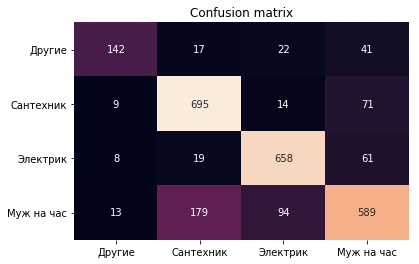

CPU times: user 2.29 s, sys: 472 ms, total: 2.76 s
Wall time: 2.18 s


In [51]:
%%time
param = [
    {'alpha': [0.1, 1.0], 'fit_prior':[True, False]},
]
ikomek_scorer = make_scorer(ikomek_accuracy)
model = model = MultinomialNB()
cv = GridSearchCV(model, param, cv = 10, scoring=ikomek_scorer)
logreg = Pipeline([
                    ('tfidf', vec_model),
                    ('clf', cv),
               ])
logreg.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", cv.best_params_)
print("accuracy :", cv.best_score_)
test_score = logreg.score(X_test, y_test)
print('Test score: ', test_score)
print_result(logreg, test_text, X_test, y_test, cv)
dump(logreg, 'data/nb.joblib')

In [52]:
data4['lemmas'] = data4.user_request.apply(lambda x: clear_text(x))
for index, row in data4.iterrows():
    if len(row['lemmas']) < 3 or len(row['lemmas'].split(' ')) < 2:
        data4.drop(index, inplace=True)
print(data4.service_name.unique())
print(data4.service_id.unique())
data4.head()

['Ремонт компьютеров' 'Уборка помещений' 'Видеонаблюдение'
 'Автоматические ворота, рольставни' 'Ремонт стиральных машин']
[13  9 24 25 61]


,contract,service_id,service_name,user_request,lemmas
3,573,13,Ремонт компьютеров,рейтинг нулевой,рейтинг нулевой
4,617,13,Ремонт компьютеров,пробный заказ на новой версии,пробный новый версия
6,650,13,Ремонт компьютеров,пуш есть или нет на горячий заказ,пуша горячий
7,651,13,Ремонт компьютеров,покрасить намордник у собаки,покрасить намордник собака
9,664,13,Ремонт компьютеров,сделать рекламу на окна,сделать реклама окно


In [53]:
X = data4.lemmas
Y = data4.service_id
X4_train, X4_test, y4_train, y4_test = train_test_split(X, Y, test_size=0.33, random_state=42)

/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


tuned hpyerparameters :(best parameters)  {'alpha': 0.1, 'fit_prior': True}
accuracy : 0.946843853820598
Test score:  0.9194630872483222
Predicted service ID:  [25]
Predic_proba :  [[0.12624585 0.09302326 0.20930233 0.3654485  0.20598007]]
Precision:   0.95
Recall:   0.89
F1-measure:   0.91
Accuracy:   0.92
              precision    recall  f1-score   support

           9       1.00      0.91      0.95        23
          13       1.00      0.70      0.82        20
          24       0.96      0.96      0.96        26
          25       0.85      1.00      0.92        53
          61       0.92      0.89      0.91        27

    accuracy                           0.92       149
   macro avg       0.95      0.89      0.91       149
weighted avg       0.93      0.92      0.92       149



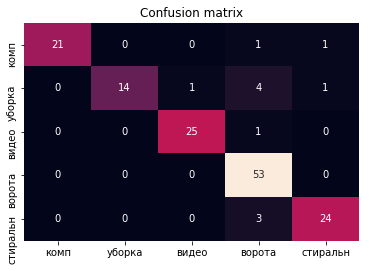

CPU times: user 848 ms, sys: 912 ms, total: 1.76 s
Wall time: 9.01 s


In [54]:
%%time
param = [
    {'alpha': [0.1, 1.0], 'fit_prior':[True, False]},
]
ikomek_scorer = make_scorer(ikomek_accuracy)
model4 = MultinomialNB()
vec_model4 = TfidfVectorizer()
cv4 = GridSearchCV(model4, param, cv = 10, scoring=ikomek_scorer, n_jobs=7)
logreg4 = Pipeline([
                    ('tfidf', vec_model4),
                    ('clf', cv4),
               ])
logreg4.fit(X4_train, y4_train)
print("tuned hpyerparameters :(best parameters) ", cv4.best_params_)
print("accuracy :", cv4.best_score_)
test_score = logreg4.score(X4_test, y4_test)
print('Test score: ', test_score)
print_result(logreg4, test_text, X4_test, y4_test, cv4, lab=['комп', 'уборка', 'видео',
 'ворота', 'стиральн'])
dump(logreg4, 'data/nb4.joblib')